# Creating the services and testing

Now that we have defined the pipeline we want to build, the components it consits of and the inputs and outputs of each of the components, we can start writing the services and some simple web applications for testing.  

We are going to be using Flask for creating the web applications for the microservices. Flask is a micro web framework written in Python. If you are not familiar with Flask or web frameworks, make sure to look through the documentation at https://flask.palletsprojects.com/en/3.0.x/.

The web applications are mainly created as a way to test the individual components before moving on. Later the communication will happen through grpc instead of through the web applications, but as most people might be more familiar with web applications, we will first use them to test the services. If you feel comfortable with grpc and the service code, you can also move directly on to implementing the grpc code. 

## Data component
Let's start by looking at the data collection and cleaning component, which in the future will be referred to as the data component. We know that the input should be some raw stock price data. We also have a base for the code that the service should consist of, as this is present in the stock_price_prediction notebook. Lastly we know that the output should be the cleaned data split into training and testing sets. Let's first define the service, or function, that does the cleaning and the splitting:

```python
def clean_data(csv_file):
    data = pd.read_csv(csv_file)
    data['Date'] = pd.to_datetime(data['Date'])
    data['Previous_Close'] = data['Close'].shift(1)
    data = data.dropna()
    
    x = data[['Previous_Close']]
    y = data['Close']
    dates = data['Date']
    
    x_train, x_test, y_train, y_test, dates_train, dates_test = train_test_split(
        x, y, dates, test_size=0.2, shuffle=False
    )
    
    # Flatten the lists
    x_train_flat = [item for sublist in x_train.values for item in sublist]
    x_test_flat = [item for sublist in x_test.values for item in sublist]
    y_train_flat = y_train.tolist()
    y_test_flat = y_test.tolist()
    dates_train_str = dates_train.dt.strftime('%Y-%m-%d').tolist()
    dates_test_str = dates_test.dt.strftime('%Y-%m-%d').tolist()
    
    return x_train_flat, x_test_flat, y_train_flat, y_test_flat, dates_train_str, dates_test_str
```
Here we have decided that the function should take a csv file containing the input data. Next the function changes the format of the Date column, assumes the column close is the target variable and therefor creates a feature called Previous_Close which is the close value of the previous day. Next the function drops the first row of data as it will contain NaN values. The function then saves the previous close column values to a variable called x, as these are the values used to make predictions. It saves the Close column values to a variable called y as these are the values that will be predicted, and are thought to depend on x. Next the function splits the datasets into training and testing sets using the function train_test_split(), and lastly flattens the lists before returning them.

Now that we have the basic service ready, we can implement the actual web application and it's routes. As mentioned, this is done mainly for testing purposes and the application code will not be necessary later on, so if you feel comfortable with the service code and with using grpc, you can move directly on to the next chapter after reviewing all of the service code for the different component. However, if you want to test the services, then let's start by importing the necessary dependencies,  defining the app using the Flask syntax and then for testing define the function for the main route to print a message saying "This is the data cleaning service!":

```python
from flask import Flask
import requests
import sys
import os

current_dir = os.path.dirname(os.path.abspath(__file__))
parent_dir = os.path.join(current_dir, '../')
sys.path.append(parent_dir)
from data_service import clean_data

app = Flask(__name__)

@app.route("/")
def welcome_message():
    return "<p>This is the data cleaning service!</p>"

#Add other routes here

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
```
If you want, you can test the application already at this point by saving the code to an app.py file and running "python app.py" in the folder where the code is saved. If you then visit the webaddress where the app is running, you should see the message.

Next, let's define a route for the actual data cleaning where we will call the function we wrote previously. The function should return the cleaned data.

```python
#Add this between main route and the run command

@app.route("/get_cleaned_data")
def get_cleaned_data():
    csv_file = './MSFT.US.csv'
    x_train_flat, x_test_flat, y_train_flat, y_test_flat, dates_train_str, dates_test_str = clean_data(csv_file)

    return {
        'message': 'Data cleaned successfully!',
        'x_train': x_train_flat,
        'x_test': x_test_flat,
        'y_train': y_train_flat,
        'y_test': y_test_flat,
        'dates_train': dates_train_str,
        'dates_test': dates_test_str
    }
```
## Testing the data component

Now we would recommend you to test this function by running the app with the same command as previously in the folder containing the app.py file:

```shell
python app.py
```
Now as output you should see the following in the terminal:
```shell
* Serving Flask app 'app'
 * Debug mode: off
WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.101:5000
Press CTRL+C to quit
```

Go ahead and open the web address where the app is running. You should see something like this: 
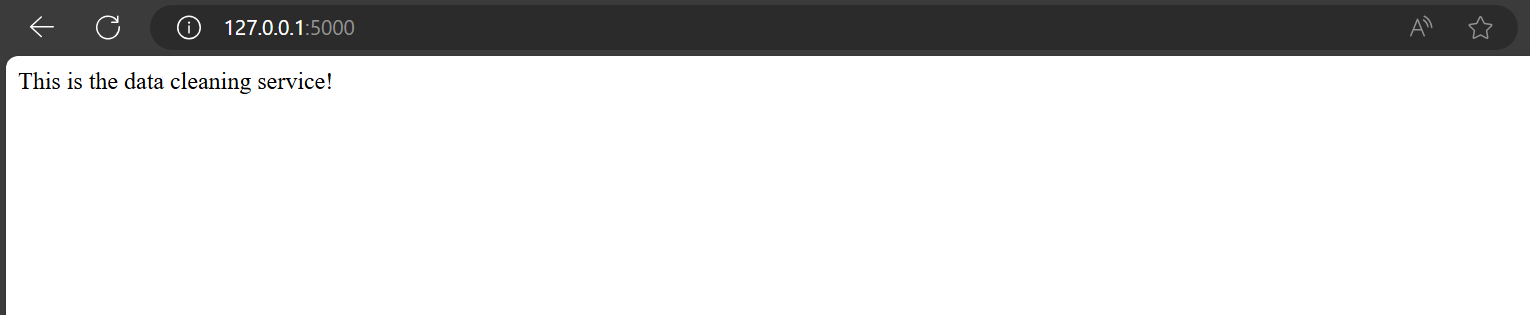

Now if you change the route to the /get_cleaned_data route you should see the following:
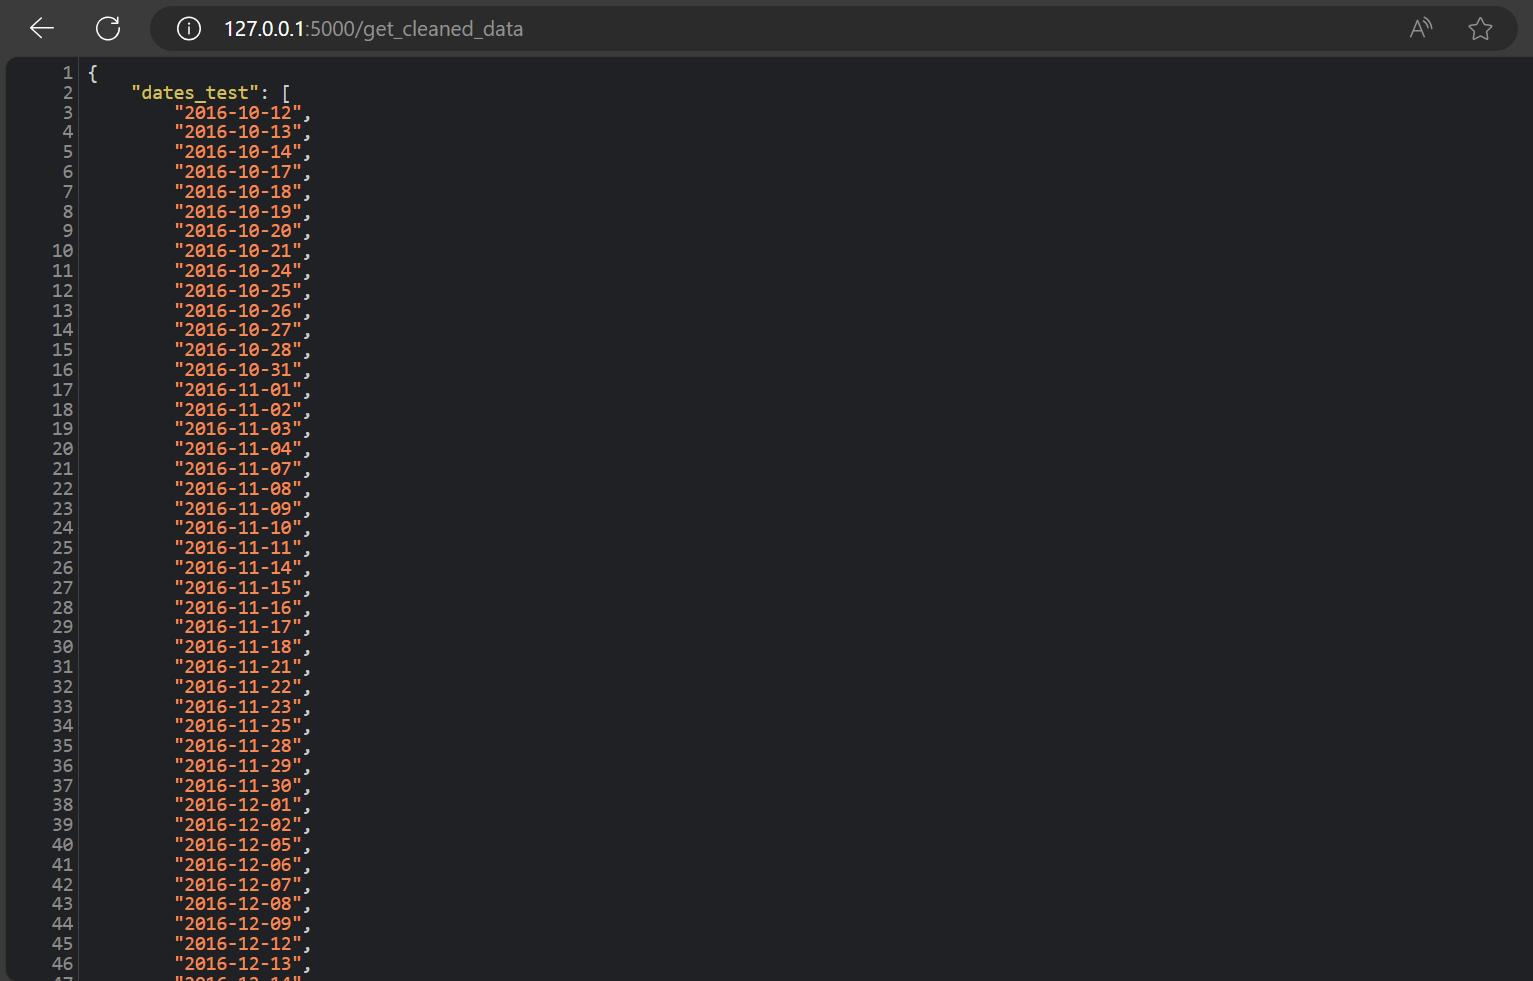

The output displayed is the cleaned data returned by the service. It is quite a long list, but if you scroll down you can see that it contains all the necessary data, that is train_dates, train_x, train_y, test_dates, test_x and test_y. The testing can also be done using postman. To use postman, enter the web address of the data application into the URL field, and speicify the request method to be get. If you then press send you should see the returned text:

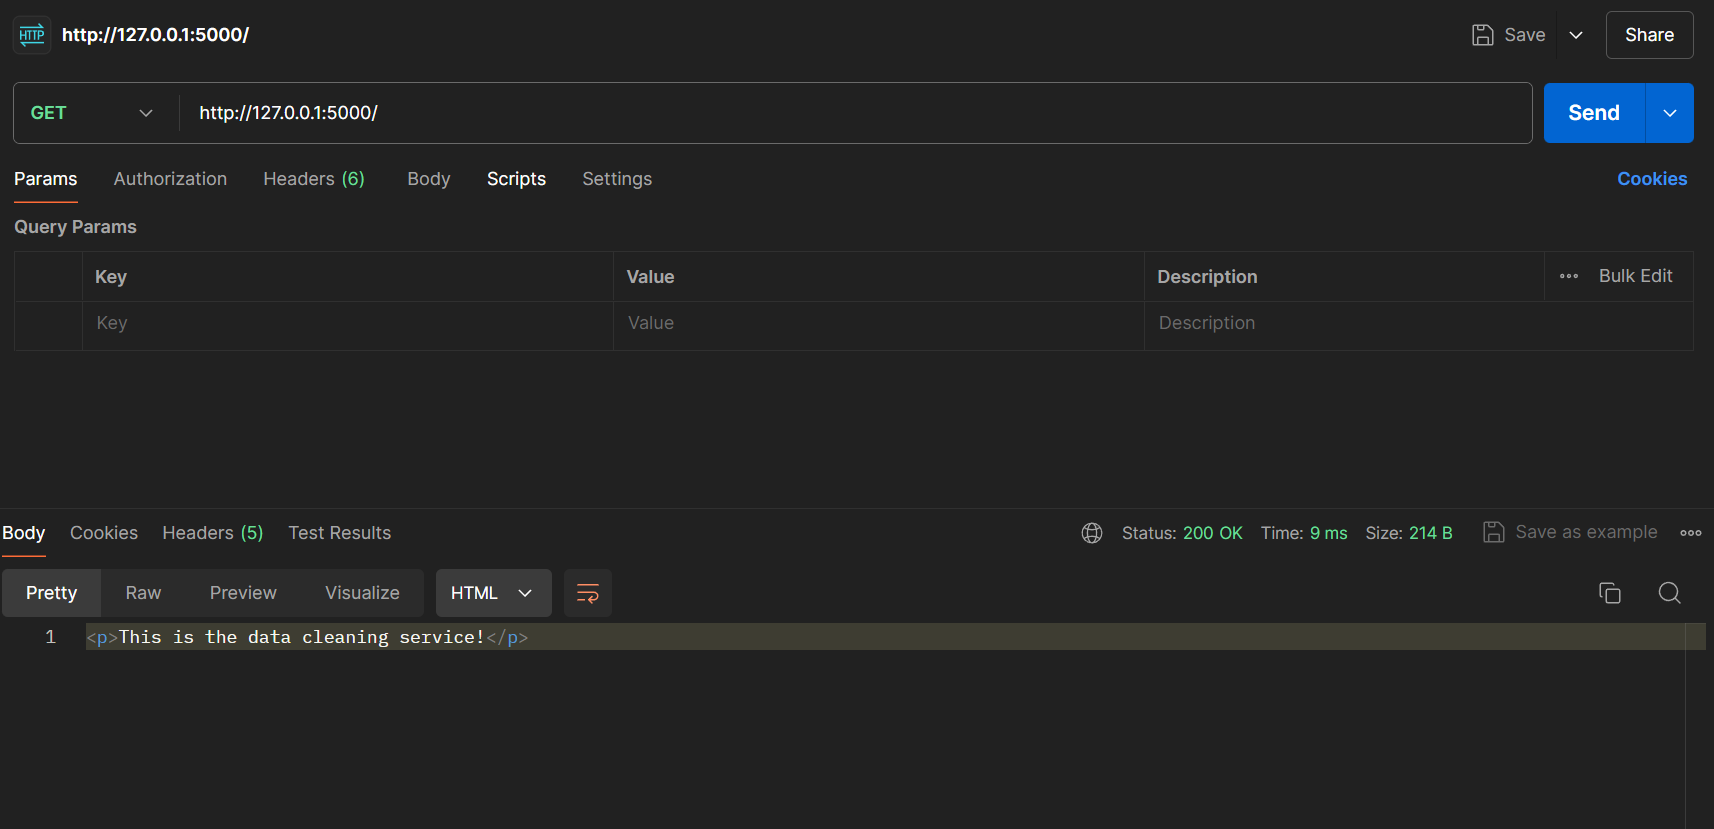

If you then again add /get_cleaned_data to the end of the address you should see the cleaned data returned. 

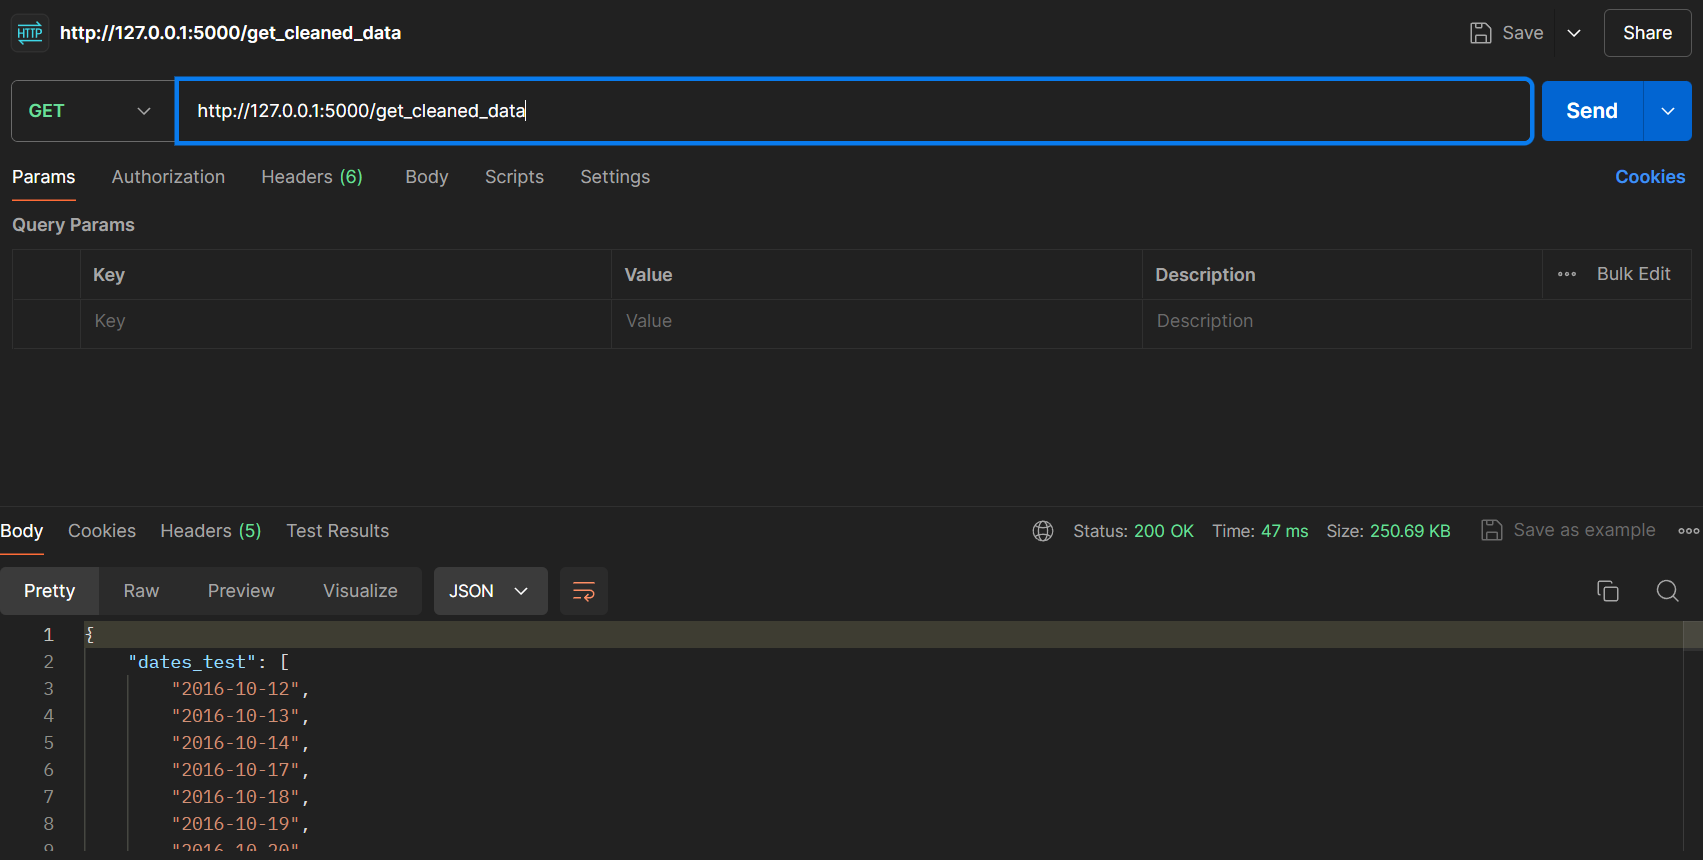

We have now confirmed that the service works as expected. For further debugging and testing you can also use print statements. 

Now we have defined the necessary functions for the data component. We still need to somehow send the cleaned data forward to the next service. We will come back to this after creating the training component. For now, we will test the code we have written so far, and then move on to the next component. 


## Training component. 

Now let's repeat the same steps for the training component. 
1) Define the service
2) Create the app and the main directory
3) Define the directory that calls the service function
4) test the application

So first let's define the service. We know it should receive the cleaned data and train a linear regression model before returning the trained model. We have to take into consideration that the x_train list was flattened in the data component (This was done to simplify future steps once we implement grpc), but we need it to be 2D, so a list containing lists. To achieve this we need to include the following line:

```python
x_train = np.array(x_train).reshape(-1, 1)
```
Besides this addition, we can use the same code as in the stock_price_prediction notebook. Here is the train_model function:

```python
import numpy as np
from sklearn.linear_model import LinearRegression

def train_model(x_train, y_train):
    model = LinearRegression()
    #make x_train 2D
    x_train = np.array(x_train).reshape(-1, 1)
    model.fit(x_train, y_train)
    
    return model
```

Now we need to create the app and define the main route. We follow the same structure as for the data component and get the following: 

```python
from flask import Flask, request
from training_service import train_model
import sys
import pickle
import base64
import requests
sys.path.append('../')


app = Flask(__name__)


@app.route("/")
def welcome_message():
    return "<p>This is the training service!</p>"


#Add other routes here

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5001)
```

Again, you can test the app already at this point to make sure that you can run it properly.

Now we need to define the route from which the service function will be called. Since we need to send the trained model to the next component, we have converted it into binary before returning it. 

We need to consider how we're going to get the cleaned data from the data component. In order to get the cleaned data, we will simply make a request to the data component, to the get_cleaned_data route, which will directly return all the cleaned data. We don't need to change anthing about the data component code as it already has all necessary functions for us to utilize it. 

```python
# add this between the main route and the run command 
@app.route("/train_model")
def train_model_cf():

    response = requests.get('http://localhost:5000/get_cleaned_data')
    data = response.json()
    if data:
        x_train_flat = data['x_train']
        y_train_flat = data['y_train']

        model = train_model(x_train_flat, y_train_flat)

        if not hasattr(model, 'predict'):
            return {'error': "The trained model does not have a 'predict' method."}

        try:
            model_base64 = base64.b64encode(pickle.dumps(model)).decode('utf-8')
        except Exception as e:
            return {'error': f"Error serializing model: {str(e)}"}

        return {'model': model_base64, 'x_test' : data['x_test'], 'y_test' : data['y_test'], 'dates_test' : data['dates_test']}
    else:
        return "No data provided", 400

```
When making the request to the data component, we expect it to return the necessary data, that is x_train, y_train, dates_train, y_test, x_test, dates_test. We will then use this data to train the model and finally return all the necessary data for the next component, the testing component, which needs all of the testing values as well as the model. 

This way of communication between components is called a webhook. A webhook is a method for augmenting or altering the behavior of a web application with custom callbacks, allowing real-time data sharing and event notifications between different systems by sending HTTP requests to a specified URL when certain events occur.

## Testing the training component and communication with the data component

To run the tests, we are again going to use either a web browser or postman, you can pick whichever you felt the most comfortable with. This time, we are also testing if the communication between the two components work, but let's start by checking that we can run the training component successfully before proceeding. In a new terminal with the venv activated, run the same command as previuosly:
```shell
python app.py
```
but this time in the folder containing the training app. Make sure the data app is also running. To test the training app we can again visit the web page or make a get request through postman. This should be the output: 

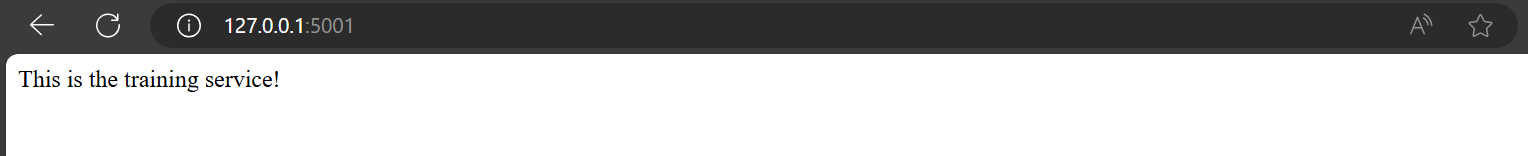

We now see that the app seems to be running. Let's test the training function now! You can visit or make a get request to the following webpage in order to test the training: http://127.0.0.1:5001/train_model

If everything worked as expected, you should see a list of the data returned. It should contain all the testing values as well as the trained model. If you scroll down, you should be able to see the model in the list:

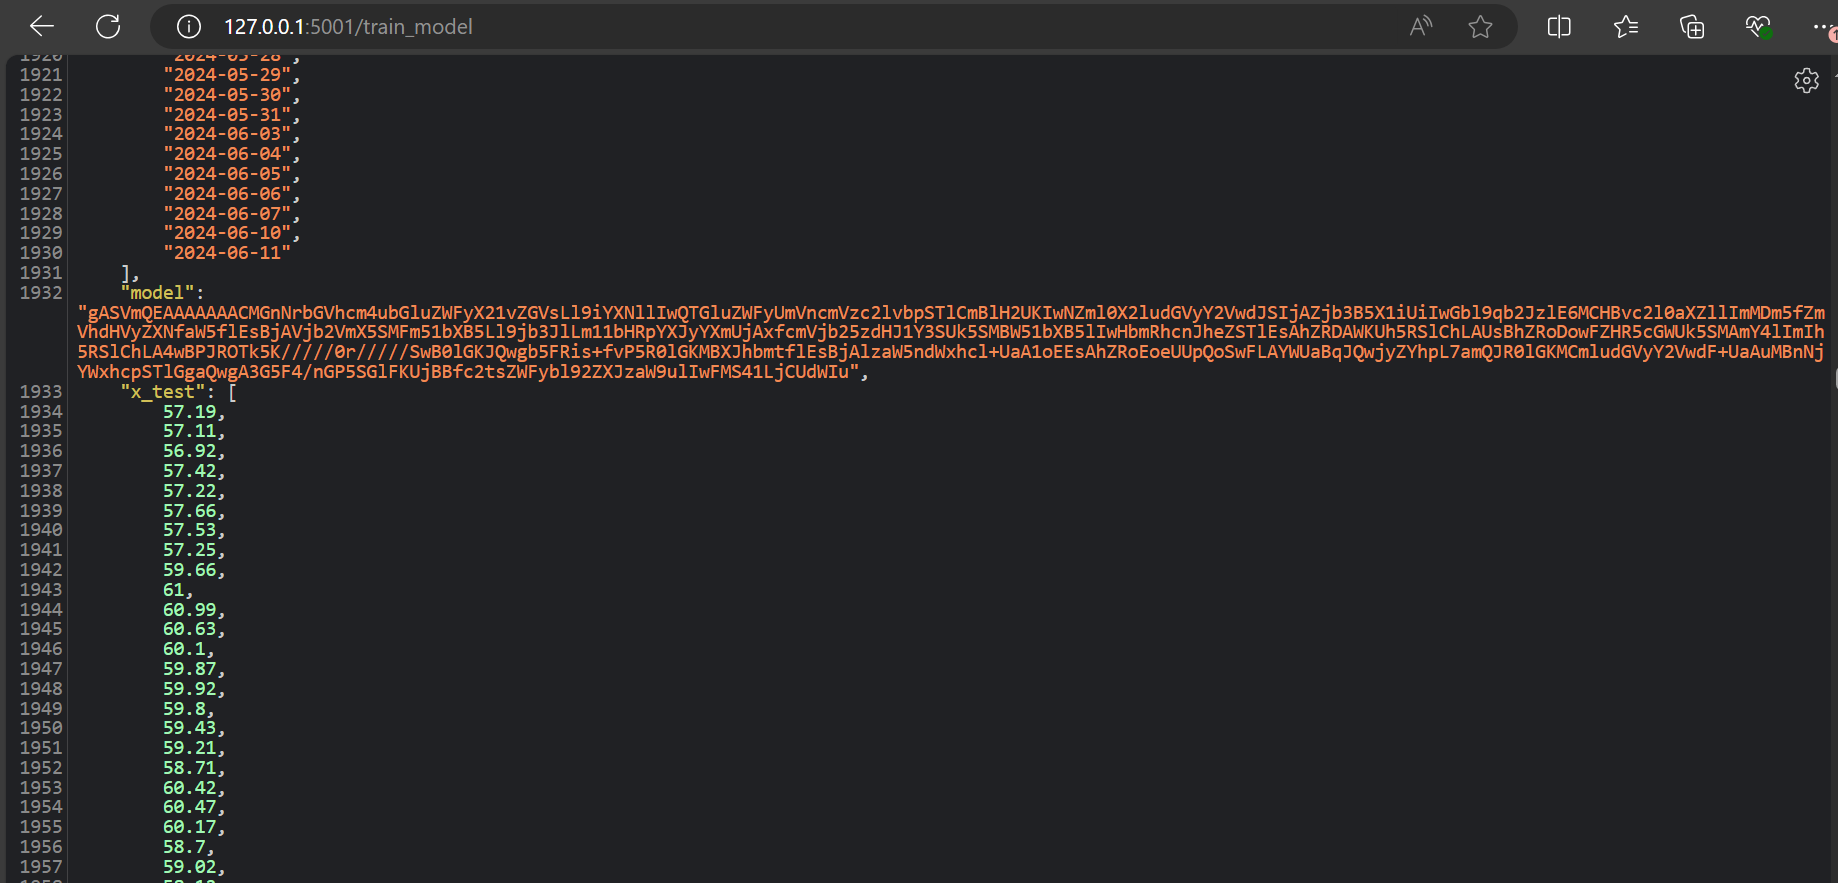

Now we have successfully tested the training service and the communication with the data service. These tests are however quite basic, and do not test all of the code used. We will later present unit tests that can be used to test the services more thoroughly and reliably.

Now we only have the testing component left to implement before we can test the entire pipeline!

## Model Testing component

Aain, we will follow the same steps as for the data and the training component:

1) Define the service
2) Create the app and the main directory
3) Define the directory that calls the service function
4) test the application

For the service, we know that it should take all the data sets, x_train, y_train, dates_train, t_test, y_test and dates_test as well as the trained model. From the stock price prediction notebook we have an outline for how to create the service. We will make some prediction, calcuate the RMSE value and plot the results. The difference now however, is that we need save the image and display it on the webpage. Here is the resulting service:

```python 
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def test_model(model, x_test, y_test, dates_test):
    x_test = np.array(x_test).reshape(-1, 1)
    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    #plot the results:
    plt.figure(figsize=(14, 7))
    plt.plot(dates_test, y_test, label='Actual')
    plt.plot(dates_test, y_pred, label='Predicted')

    # Format the date on the x-axis
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))  # Set major ticks every 10 days
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.gcf().autofmt_xdate() 

    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('MSFT Stock Price Prediction')
    plt.legend()
    plt.grid(True)
    current_time_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    plot_filename = f'test_plot_{current_time_str}.png'
    plt.savefig(plot_filename)

    return rmse, plot_filename

```
In this code we again first make sure the x_test is a 2D list and then make some predictions using the model's predict function and entering the x_test values. With the predictions and the actual y_test values we calculate an RMSE value which describes how correct the predictions were. Finally we create a plot to visualize how close the predicted values were to the real ones and save it before returning both the RMSE value and the plot filename.

This time, since we've gone throught the process of creating first the app and then the main route, we're just going to look at the entire app as a whole. Here is the code for the testing app: 

```python
import pickle
import base64
from flask import Flask, request, send_file, jsonify
from test_service import test_model
import matplotlib
import requests
matplotlib.use('Agg')  # Use non-interactive backend


app = Flask(__name__)

@app.route("/")
def welcome_message():
    return "<p>This is the testing service!</p>"


@app.route("/test_model")
def test_model_cf():
    response = requests.get('http://localhost:5001/train_model')
    data = response.json()
    
    try:
        model_data = data.get('model')
    except Exception as e:
        return {'error': f"Error loading model data: {str(e)}"}

    try:
        model_binary = base64.b64decode(model_data)
        model = pickle.loads(model_binary)
    except Exception as e:
        return {'error': f"Error loading model: {str(e)}"}
    
    if not hasattr(model, 'predict'):
        return {'error': "The loaded model does not have a 'predict' method."}

    
    try:
        x_test = data.get('x_test')
        y_test = data.get('y_test')
        dates_test = data.get('dates_test')
    except Exception as e:
        return {'error': f"Error loading test data: {str(e)}"}

    try:
        rmse, plot_filename = test_model(model, x_test, y_test, dates_test)
        print("tested model successfully!")
    except Exception as e:
        return jsonify({'error': f"Error testing model: {str(e)}"}), 500


    plot_url = f'/get_plot/{plot_filename}'

    response = {
        'rmse': rmse,
        'plot_url': plot_url
    }

    return response 


@app.route("/get_plot/<plot_filename>")
def get_plot(plot_filename):
    return send_file(f'./{plot_filename}', mimetype='image/png')



if __name__ == "__main__":
    app.run(host='0.0.0.0', port=5002)

```
In this code we first create the app and the main route where we simply return a string explaining which service it is. Then we have the /test_model route where we again use a webhook to get the trained model, decode and deserialize the model and call the testing function from the service file. We then return the returned RMSE value and the plot. Notice that we have added quite a bit more try and except blocks compared to the previous components. This is mainly done to guarantee that the model got sent, deserialized and decoded correctly. 

Now that we have all three components ready we can test the full pipeline!

## Testing the entire pipeline

WRITE THIS ONCE YOU HAVE DECIDED HOW THE TESTING SHOULD BE DONE 




